In [1]:
import matplotlib as mpl
mpl.rcParams.update({
    'font.family': 'serif',
})

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

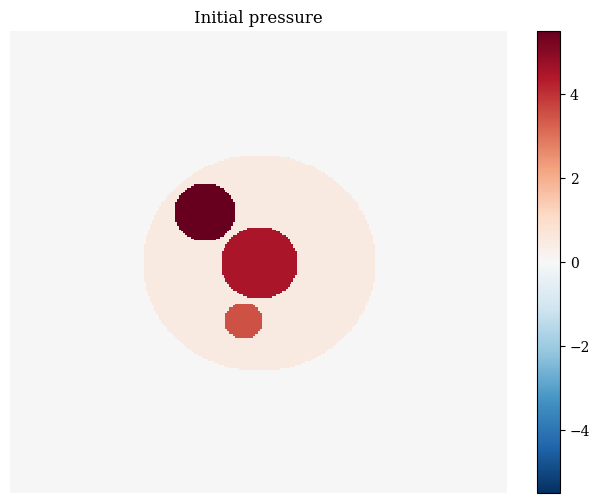

Sensors parameters:


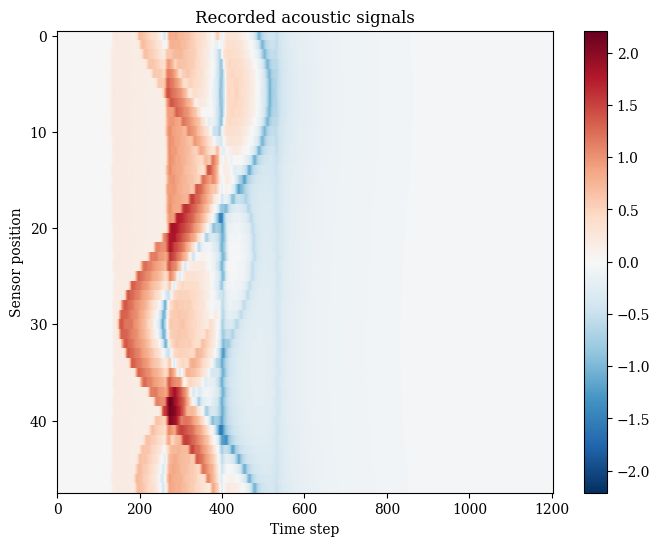

In [2]:
%run ./homogeneous_medium_sensors.ipynb

In this notebooks, we will work on simulated measurements. To make things (a tiny bit) more realistic, we'll add some coloured noise to each sensor trace

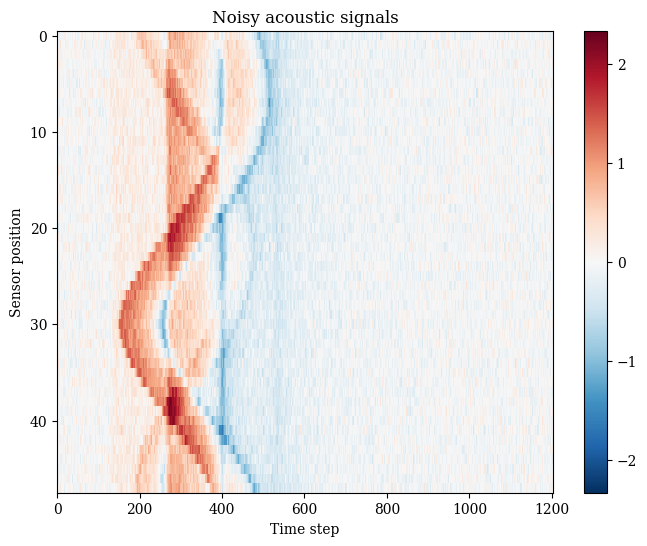

In [3]:
import numpy as np
from jax import grad, random

from jwave.signal_processing import smooth

# Add colored noise
noise = random.normal(random.PRNGKey(42), sensors_data.shape)
for i in range(noise.shape[1]):
    noise = noise.at[:, i].set(smooth(noise[:, i]))

noisy_data = sensors_data + 0.2 * noise

# Show noisy traces
_field = FourierSeries(noisy_data.T, domain)
show_field(_field, "Noisy acoustic signals")
plt.xlabel("Time step")
plt.ylabel("Sensor position")
plt.axis("on")
plt.show()

## Automatic differentiation

In `jwave`, it is possible to take the gradient with respect to any scalar loss, as shown in the following example. The gradients will have the same datatypes as the inputs of to the function, so `Field` gradients will be mapped to `Field` objects.

Here, we write a simple time reversal algorithm using autodiff. Note that time-reversal is proportional to the derivative operator of the `MSE` loss with respect to the measurement data, applied with zero initial conditions.

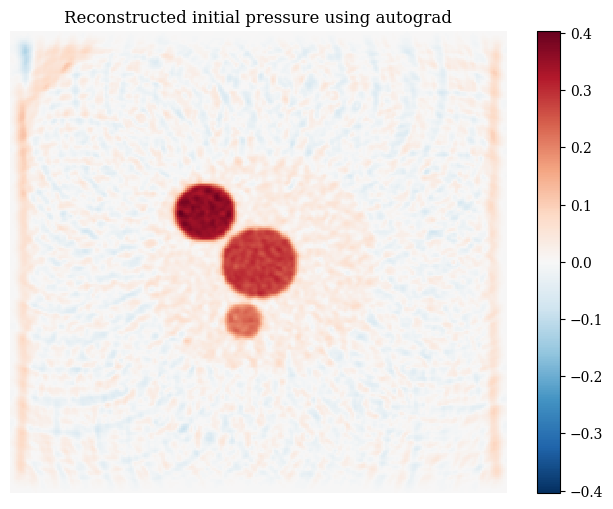

In [4]:
# The following uses the reciprocity of the wave equation to generate
# a time reversal imaging algorithm
def solver(p0):
    return simulate_wave_propagation(medium, time_axis, p0=p0, sensors=sensors)


@jit  # Compile the whole algorithm
def lazy_time_reversal(measurements):
    def mse_loss(p0, measurements):
        p0 = p0.replace_params(p0.params)
        p_pred = solver(p0)[..., 0]
        return 0.5 * jnp.sum(jnp.abs(p_pred - measurements) ** 2)

    # Start from an empty field
    p0 = FourierSeries.empty(domain)

    # Take the gradient of the MSE loss w.r.t. the
    # measured data
    p_grad = grad(mse_loss)(p0, measurements)

    return -p_grad


# Reconstruct initial pressure distribution
recon_image = lazy_time_reversal(noisy_data)

# Show reconstructed field
show_field(recon_image, "Reconstructed initial pressure using autograd")

In [5]:
# Timings for the reconstruction algorithm, should be
# ~ 2x the forward function.
%timeit lazy_time_reversal(noisy_data).params.block_until_ready()

393 ms ± 435 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


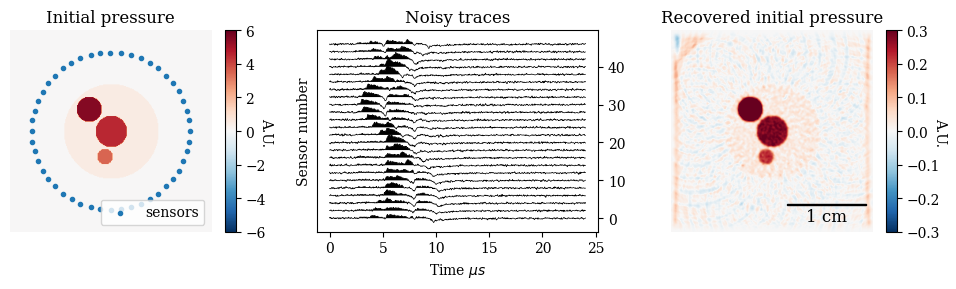

In [8]:
from scipy.interpolate import interp1d

# Save for paper
fig, ax = plt.subplots(1,3, figsize=(10,3), dpi=100)

im1 = ax[0].imshow(p0.on_grid, cmap="RdBu_r", vmin=-6, vmax=6)
cbar = fig.colorbar(im1, ax=ax[0])
cbar.ax.get_yaxis().labelpad = 5
cbar.ax.set_ylabel('A.U.', rotation=270)
ax[0].axis('off')
ax[0].set_title('Initial pressure')
ax[0].scatter(x, y, label="sensors", marker='.')
ax[0].legend(loc="lower right")

# Plotting traces
# adapted from this gist: https://gist.github.com/kwinkunks/f594b243e582666b5a808520e9add262
data = np.asarray(noisy_data).T
time = np.asarray(time_axis.to_array())

skip=2
perc=99.0
gain=1.3
oversampling=100
rgb=(0, 0, 0)
alpha=1.0
lw=0.5

ntraces, nt = data.shape
rgba = list(rgb) + [alpha]
sc = np.percentile(data, perc)  # Normalization factor
wigdata = data[::skip]
xpos = np.arange(ntraces)[::skip]

for y_trace, trace in zip(xpos, wigdata):
    amp = gain * trace / sc + y_trace
    t = 1e6 * time
    hypertime = np.linspace(t[0], t[-1], (oversampling * t.size - 1) + 1)
    interp = interp1d(t, amp, kind='cubic')
    hyperamp = interp(hypertime)

    # Plot the line, then the fill.
    ax[1].plot(hypertime, hyperamp, 'k', lw=lw)
    ax[1].fill_between( hypertime, hyperamp, y_trace,
                     where=hyperamp > y_trace,
                     facecolor=rgba,
                     interpolate=True,
                     lw=0,
                     )

ax[1].yaxis.tick_right()
ax[1].set_title('Noisy traces')
ax[1].set_ylabel("Sensor number")
ax[1].set_xlabel("Time $\mu s$")

im1 = ax[2].imshow(recon_image.on_grid, cmap="RdBu_r", vmin=-0.3, vmax=0.3)
cbar = fig.colorbar(im1, ax=ax[2])
cbar.ax.get_yaxis().labelpad = 5
cbar.ax.set_ylabel('A.U.', rotation=270)
ax[2].axis('off')
ax[2].set_title('Recovered initial pressure')

fontprops = fm.FontProperties(size=12)
scalebar = AnchoredSizeBar(
    ax[2].transData,
    100, '1 cm', 'lower right', 
    pad=0.3,
    color='black',
    frameon=False,
    size_vertical=2,
    fontproperties=fontprops)
ax[2].add_artist(scalebar)

fig.tight_layout()

plt.savefig("initial_pressure_recon.pdf")